In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
print(os.listdir("../input"))

['tmp', 'test.csv.zip', 'scalar_coupling_contributions.csv.zip', 'structures.csv.zip', 'potential_energy.csv', 'dipole_moments.csv', 'dipole_moments.csv.zip', 'mulliken_charges.csv.zip', 'test.csv', 'scalar_coupling_contributions.csv', 'structures.csv', 'sample_submission.csv', 'mulliken_charges.csv', 'potential_energy.csv.zip', 'magnetic_shielding_tensors.csv.zip', 'train.csv.zip', 'structures', 'magnetic_shielding_tensors.csv', '.gitkeep', 'train.csv', 'sample_submission.csv.zip']


In [2]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor


In [3]:
%%time

input_dir = '../work/subsample_10000'
#input_dir = '../input'

train = pd.read_csv(input_dir + '/train.csv', index_col='id')
test = pd.read_csv(input_dir + '/test.csv', index_col='id')

CPU times: user 464 ms, sys: 48 ms, total: 512 ms
Wall time: 511 ms


In [4]:
train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
300,dsgdb9nsd_000027,4,1,1JHC,145.440000
301,dsgdb9nsd_000027,4,2,2JHC,35.841400
302,dsgdb9nsd_000027,4,3,3JHN,0.969607
749,dsgdb9nsd_000052,5,1,1JHC,133.453000
750,dsgdb9nsd_000052,5,2,2JHC,11.021600


In [5]:
%%time

structures = pd.read_csv('../input/structures.csv')
structures.head()

CPU times: user 1.43 s, sys: 83.5 ms, total: 1.52 s
Wall time: 1.52 s


In [6]:
%%time

# Map the atom structure data into train and test files

def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

CPU times: user 1.84 s, sys: 412 ms, total: 2.25 s
Wall time: 2.25 s


In [7]:
%%time

# Engineer a single feature: distance vector between atoms
#  (there's ways to speed this up!)

# This block is SPPED UP

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

CPU times: user 29.3 ms, sys: 203 µs, total: 29.5 ms
Wall time: 28.2 ms


In [8]:
%%time

molecules = train.pop('molecule_name')
test = test.drop('molecule_name', axis=1)

y = train.pop('scalar_coupling_constant')

# Label Encoding
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.1 s


In [9]:
%%time

yoof = np.zeros(len(train))
yhat = np.zeros(len(test))

n_splits = 3
gkf = GroupKFold(n_splits=n_splits) # we're going to split folds by molecules

fold = 0
for in_index, oof_index in gkf.split(train, y, groups=molecules):
    fold += 1
    print(f'fold {fold} of {n_splits}')
    X_in, X_oof = train.values[in_index], train.values[oof_index]
    y_in, y_oof = y.values[in_index], y.values[oof_index]
    reg = RandomForestRegressor(n_estimators=250,
                                max_depth=9,
                                min_samples_leaf=3,
                                n_jobs=-1)
    reg.fit(X_in, y_in)
    yoof[oof_index] = reg.predict(X_oof)
    yhat += reg.predict(test)

yhat /= n_splits

fold 1 of 3
fold 2 of 3
fold 3 of 3
CPU times: user 25min 40s, sys: 1.93 s, total: 25min 42s
Wall time: 6min 43s


In [10]:
%%time

sample_submission = pd.read_csv(input_dir + '/sample_submission.csv', index_col='id')

benchmark = sample_submission.copy()
benchmark['scalar_coupling_constant'] = yhat
benchmark.to_csv('../work/atomic_distance_benchmark_on_sample.csv')

CPU times: user 1.11 s, sys: 12 ms, total: 1.12 s
Wall time: 1.12 s


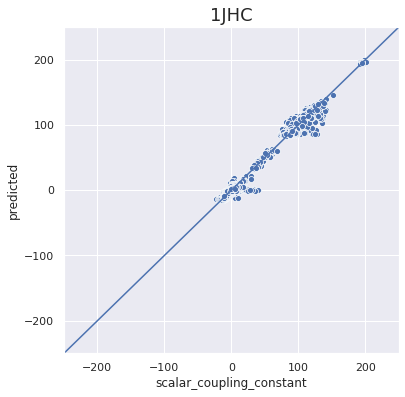

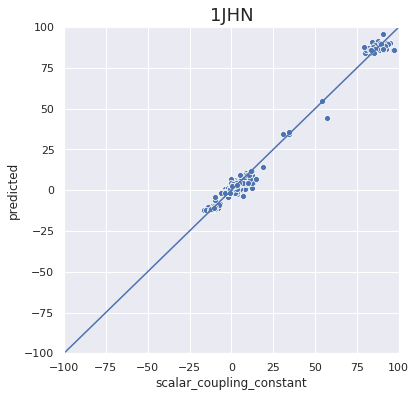

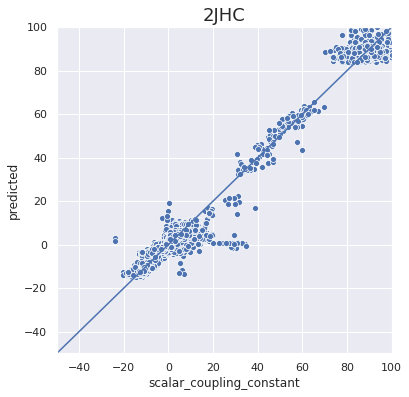

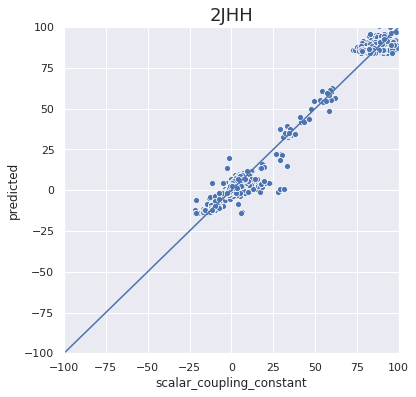

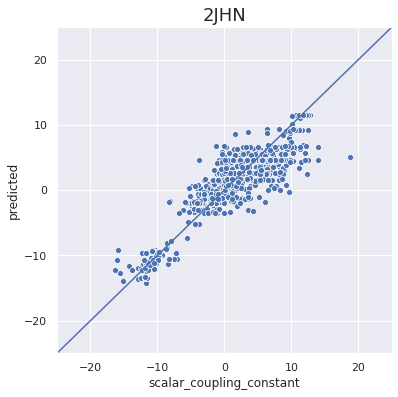

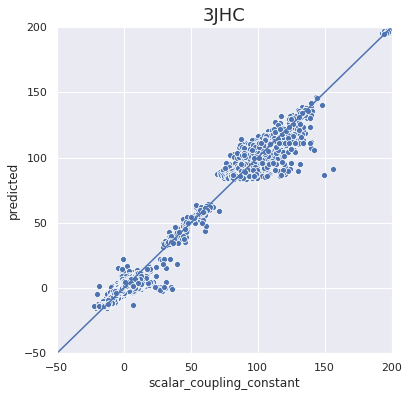

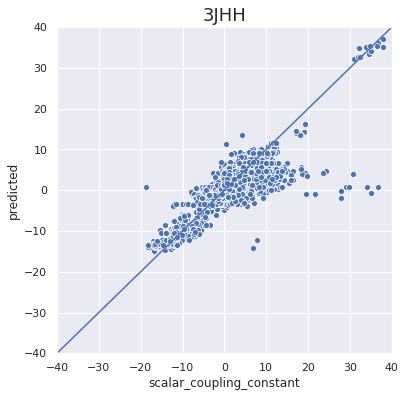

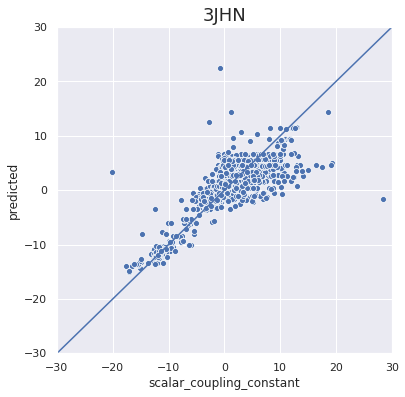

In [12]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = yoof
plot_data['type'] = pd.read_csv(input_dir + '/train.csv', index_col='id', usecols=['id', 'type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', -250, 250)
plot_oof_preds('1JHN', -100, 100)
plot_oof_preds('2JHC', -50, 100)
plot_oof_preds('2JHH', -100, 100)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -50, 200)
plot_oof_preds('3JHH', -40, 40)
plot_oof_preds('3JHN', -30, 30)